In [1]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation
from IPython.core.debugger import set_trace
from shapes import ShapesConfig, ShapesDataset
import model as modellib
import utils
from skimage.morphology import label

# Load a single image and its associated masks
id = '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
file = "../../input/stage1_train/{}/images/{}.png".format(id,id)
masks = "../../input/stage1_train/{}/masks/*.png".format(id)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]
print(num_masks)
# from IPython.core.debugger import Tracer; Tracer()()

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


27


Using TensorFlow backend.


In [130]:
print(label.__doc__)

Label connected regions of an integer array.

    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::

      1-connectivity      2-connectivity     diagonal connection close-up

           [ ]           [ ]  [ ]  [ ]         [ ]
            |               \  |  /             |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]    [x]--[ ]
            |               /  |  \         hop 1
           [ ]           [ ]  [ ]  [ ]

    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connectivity" means connected pixels have to share face,
        whereas with 8-"connectivity", they have to share only edge or vertex.
        **Deprecated, use ``connectivity`` inst

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [3]:
# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

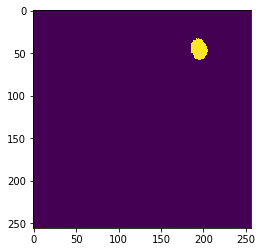

In [4]:
plt.imshow(masks[19])

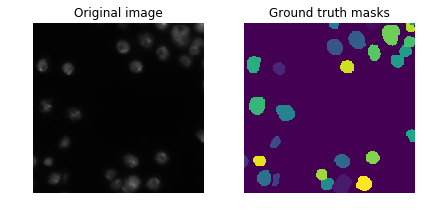

In [6]:
# Show label image
fig, axes = plt.subplots(1,2, figsize=(6,4))
axes[0].imshow(image)
axes[0].set_title("Original image")
axes[1].imshow(labels)
axes[1].set_title("Ground truth masks")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [7]:
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects
# y_pred = labels

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


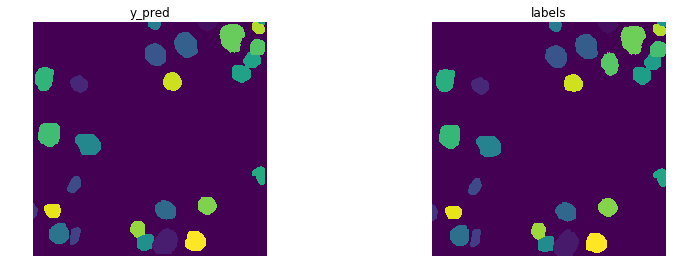

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].imshow(y_pred)
axes[0].set_title("y_pred")
axes[1].imshow(labels)
axes[1].set_title("labels")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

Text(0.5,1,'Simulated imperfect submission')

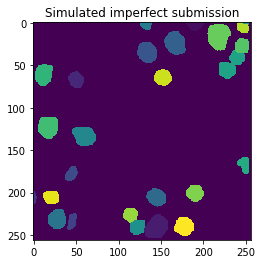

In [10]:
# Show simulated predictions
fig = plt.figure()
plt.imshow(y_pred)
plt.title("Simulated imperfect submission")

[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
(100,)


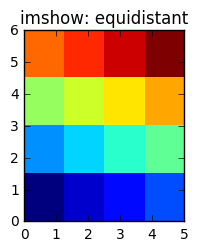

In [46]:
xedges = [0, 1, 1.5, 3, 5]
yedges = [0, 2, 3, 4, 6]



x = np.random.normal(3, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(y, x, bins=(xedges, yedges))


H = np.ones((4, 4)).cumsum().reshape(4, 4)
# print(H[::-1])  # This shows the bin content in the order as plotted
print(H)
print(y.shape)

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131)
ax.set_title('imshow: equidistant')
im = plt.imshow(H, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])


In [11]:
# Compute number of objects
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 28
Number of predicted objects: 27


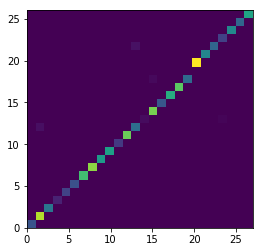

In [12]:
# Compute intersection between all objects
intersection, xedges, yedges = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))

plt.imshow(intersection[1:,1:], interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [13]:
# Compute areas (needed for finding the union between all objects)
area_true, atbins = np.histogram(labels, bins = true_objects)[:2]
area_pred, apbins = np.histogram(y_pred, bins = pred_objects)[:2]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [16]:
area_pred.shape

(1, 27)

In [17]:
# Compute union
union = area_true + area_pred - intersection

In [18]:
# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

In [19]:
# Compute the intersection over union
iou = intersection / union

In [20]:
(iou < 1).all()

True

In [21]:
threshold = 0.5
matches = iou > threshold
np.sum(matches, axis=1).shape


(27,)

In [22]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold # 0.5, 0.55, 0.6, 0.65, ... , 0.95
    true_positives = np.sum(matches, axis=1) == 1   # Correct Objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra Objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed Objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [23]:
# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.893
0.550	24	2	3	0.828
0.600	22	4	5	0.710
0.650	18	8	9	0.514
0.700	13	13	14	0.325
0.750	4	22	23	0.082
0.800	0	26	27	0.000
0.850	0	26	27	0.000
0.900	0	26	27	0.000
0.950	0	26	27	0.000
AP	-	-	-	0.335


In [9]:
# Config
config = ShapesConfig()
# config.display()

# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [60]:
shape_mask, shape_class = dataset_val.load_mask(4)
shape_labels = np.zeros((shape_mask.shape[0],shape_mask.shape[1]), np.uint16)
num_mask = shape_mask.shape[2]
for index in range(0, num_mask):
    shape_labels[shape_mask[:,:,index] > 0] = index + 1

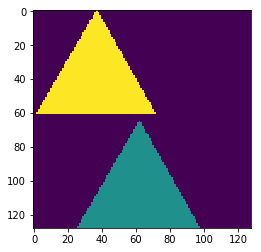

In [61]:
plt.imshow(shape_labels)

(128, 128, 3)

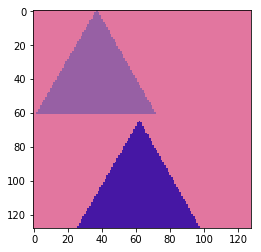

In [62]:
plt.imshow(dataset_val.load_image(4))
dataset_val.load_image(4).shape

In [63]:
# Simulate an imperfect submission
offset = 2 # offset pixels
shape_pred = shape_labels[offset:, offset:]
shape_pred = np.pad(shape_pred, ((0, offset), (0, offset)), mode="constant")
shape_pred[shape_pred == 1] = 0 # Remove one object
shape_pred, _, _ = skimage.segmentation.relabel_sequential(shape_pred) # Relabel objects
# y_pred = labels

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


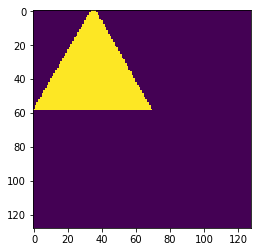

In [64]:
plt.imshow(shape_pred)

In [65]:
true_objects = len(np.unique(shape_labels))
pred_objects = len(np.unique(shape_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 3
Number of predicted objects: 2


In [67]:
intersection, xedges, yedges = np.histogram2d(shape_labels.flatten(), shape_pred.flatten(), bins=(true_objects, pred_objects))

In [68]:
intersection.shape

(3, 2)

In [69]:
intersection

array([[11732.,   186.],
       [ 2299.,     0.],
       [  190.,  1977.]])

In [71]:
area_true, atbins = np.histogram(shape_labels, bins = true_objects)[:2]
area_pred, apbins = np.histogram(shape_pred, bins = pred_objects)[:2]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [72]:
area_true.shape

(3, 1)

In [73]:
area_pred.shape

(1, 2)

In [74]:
# Compute union
union = area_true + area_pred - intersection

In [77]:
# Compute the intersection over union
iou = intersection / union

In [75]:
# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

In [76]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold # 0.5, 0.55, 0.6, 0.65, ... , 0.95
    true_positives = np.sum(matches, axis=1) == 1   # Correct Objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra Objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed Objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [78]:
# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	1	0	1	0.500
0.550	1	0	1	0.500
0.600	1	0	1	0.500
0.650	1	0	1	0.500
0.700	1	0	1	0.500
0.750	1	0	1	0.500
0.800	1	0	1	0.500
0.850	0	1	2	0.000
0.900	0	1	2	0.000
0.950	0	1	2	0.000
AP	-	-	-	0.350


In [81]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


In [82]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               4, use_mini_mask=False)

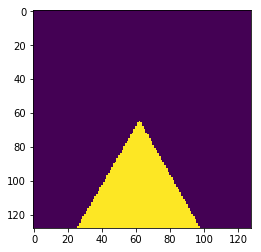

In [88]:
plt.imshow(gt_mask[:,:,0])

In [89]:
shape_class

array([3, 3], dtype=int32)

In [103]:
bbox = utils.extract_bboxes(shape_pred)

In [104]:
bbox

array([[ 0,  0, 59, 70]], dtype=int32)

In [101]:
shape_pred = shape_pred[:,:,None]

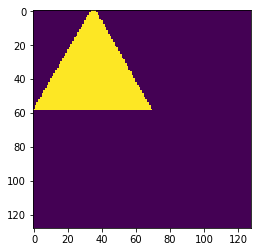

In [108]:
plt.imshow(shape_pred[:,:,0])

In [102]:
shape_pred.shape

(128, 128, 1)

In [109]:
gt_class_id.shape

(2,)

In [115]:
utils.compute_ap(gt_bbox, gt_class_id,bbox,np.array([3]), np.array([0.99]), iou_threshold=0.90)

(0.5,
 array([1., 1., 0.]),
 array([0. , 0.5, 1. ]),
 array([[0.        , 0.91431176]]))

In [127]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold # 0.5, 0.55, 0.6, 0.65, ... , 0.95
    true_positives = np.sum(matches, axis=1) == 1   # Correct Objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra Objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed Objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

# Create function to calculate mean IoU Precision at different thresholds
def val_iou(labels, y_pred):
    """
    Function takes labels and y_preds as arguments.
    labels and y_preds have to be 2D, not 3D. All the 
    objects have to be numbered inside.
    """
    # Compute number of objects
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    
    # Compute areas (needed for finding the union between all objects)
    area_true, atbins = np.histogram(labels, bins = true_objects)[:2]
    area_pred, apbins = np.histogram(y_pred, bins = pred_objects)[:2]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    # Compute intersection between all objects
    intersection, xedges, yedges = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))

    
    # Compute union
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    # Compute the intersection over union
    iou = intersection / union
    
    # Loop over IoU thresholds
    prec = []
    table = 
    print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    # Is the below required? Are you sure?
    # labels = label(y_true_in > 0.5)
    # y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [128]:
val_iou(labels,y_pred)

Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.893
0.550	24	2	3	0.828
0.600	22	4	5	0.710
0.650	18	8	9	0.514
0.700	13	13	14	0.325
0.750	4	22	23	0.082
0.800	0	26	27	0.000
0.850	0	26	27	0.000
0.900	0	26	27	0.000
0.950	0	26	27	0.000
AP	-	-	-	0.335
